**Thank You for reading this notebook!!**

**If you find this notebook useful or you just like it, please Upvote it as it would keep me motivated to update this notebook regularly.**

**And if you have any question, or find out something isn't right please comment below.**

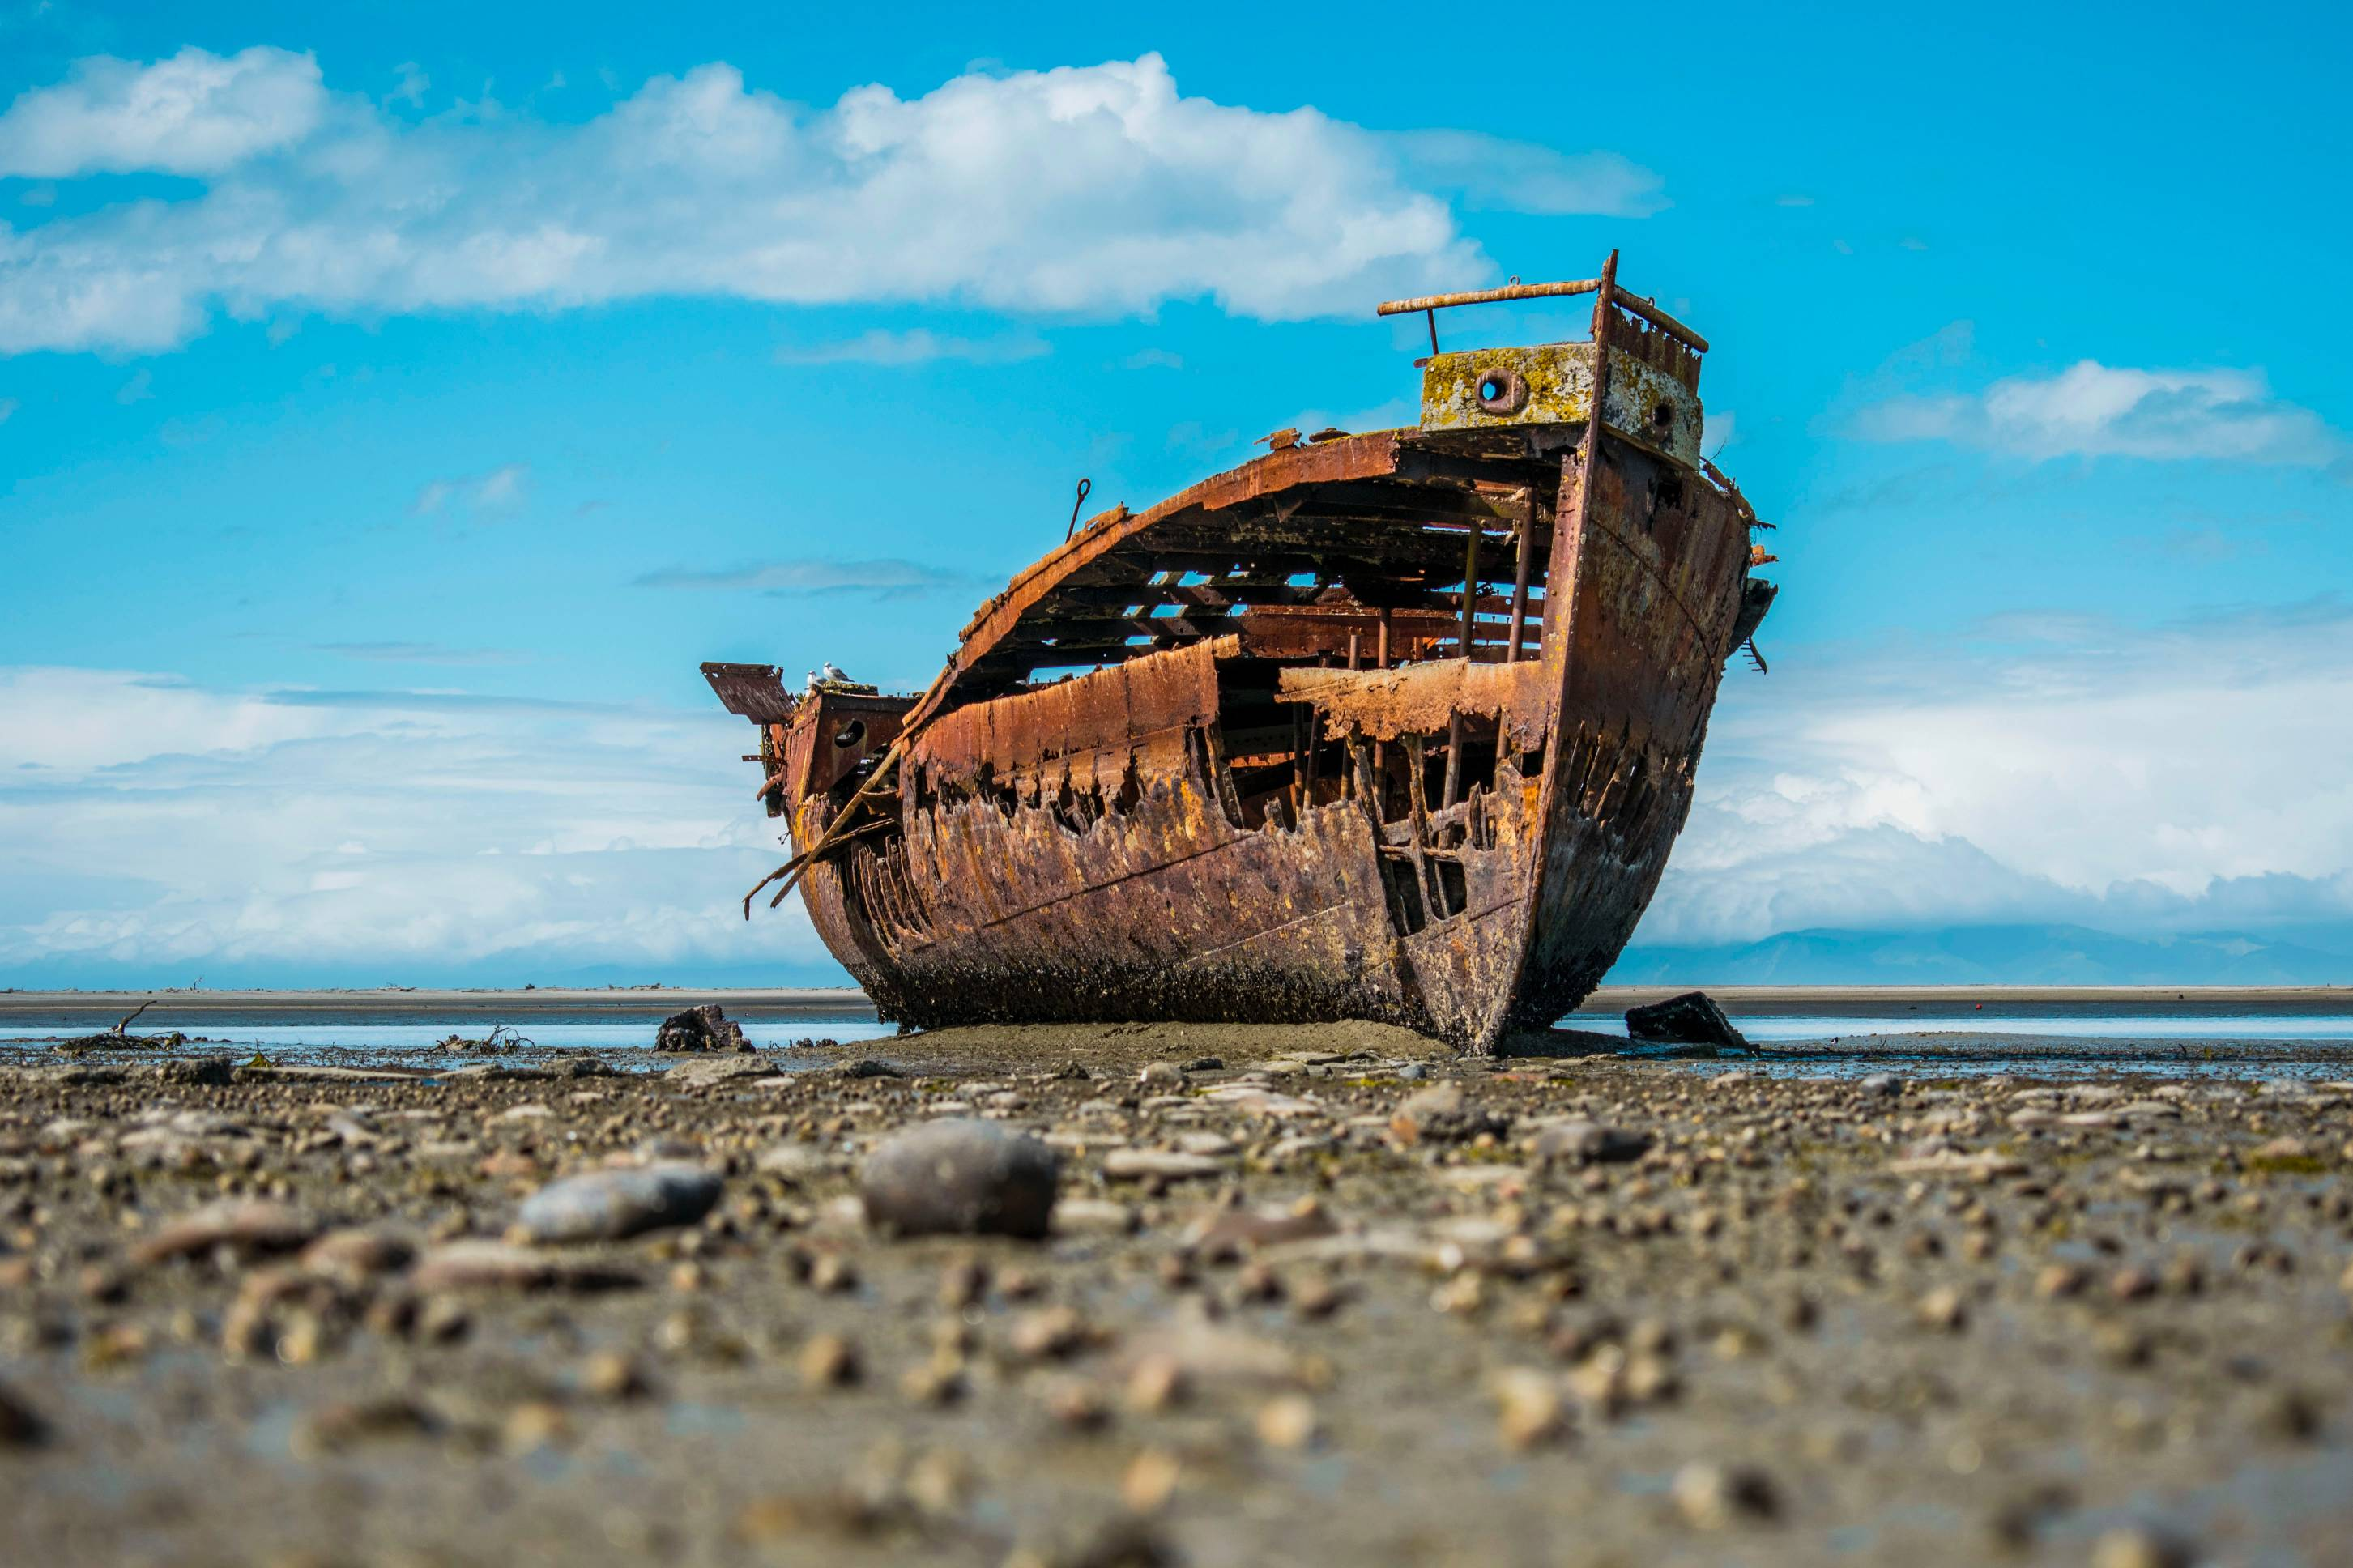

In [1]:
import numpy as np 
import pandas as pd 
import re
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats


%matplotlib inline

rcParams['figure.figsize'] = [9, 6]
sb.set_style('white')
color = 'mediumslateblue'


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


**Variable**-----------------**Definition**

survival------------------Survival

pclass------------------Ticket class

sex-------------------------Sex

Age---------------------Age in years

sibsp---------# of siblings / spouses aboard the Titanic

parch---------# of parents / children aboard the Titanic

ticket-----------------Ticket number

fare-------------------Passenger fare

cabin-------------------Cabin number

embarked-------------Port of Embarkation

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.



## First thing first...

In [2]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
PassengerId = test['PassengerId']
sample_sub = pd.read_csv("../input/titanic/gender_submission.csv")

In [3]:
sample_sub.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [6]:
train.shape, test.shape

((891, 12), (418, 11))

In [7]:
train.info()
print("-"*50)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0  

In [8]:
list(train.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

# Handling Missing Values

In [9]:
display(train.isnull().sum().sort_values(ascending=False))
print("-"*50)
display(test.isnull().sum().sort_values(ascending=False))

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

--------------------------------------------------


Cabin          327
Age             86
Fare             1
Embarked         0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
PassengerId      0
dtype: int64

In [10]:
percent_missing = (train.isnull().sum()/train.isnull().count()) * 100
percent_missing = percent_missing[percent_missing>0].sort_values(ascending=False)

display(percent_missing.to_frame(name="Percent Missing"))

,Percent Missing
Cabin,77.104377
Age,19.865320
Embarked,0.224467


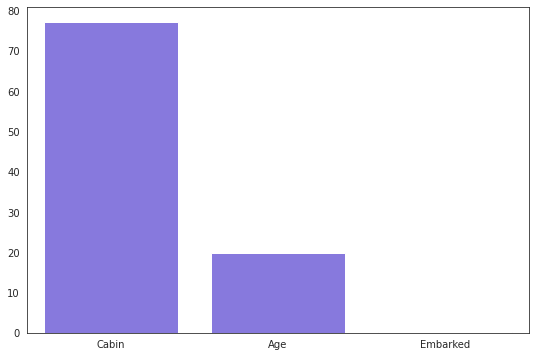

In [11]:
sb.barplot(x=percent_missing.index, y=percent_missing, color=color)

In [12]:
train['Cabin'].describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

> Okay so here we can see that 'Cabin' has 77% of missing values. We must drop cabin as it will do more bad than good.

In [13]:
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

In [14]:
train['Age'].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

In [15]:
for df in [train, test]:
    age_avg = df['Age'].mean()
    age_std = df['Age'].std()
    age_null_count = df['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    df['Age'][np.isnan(df['Age'])] = age_null_random_list
    df['Age'] = df['Age'].astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
test['Age'].isnull().sum()

0

In [17]:
train['Embarked'].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

In [18]:
train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [19]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

'Embarked' has only 2 missing values and three unique values in column. We can see that 'S' is the most common value. Hence, we can fill the missing two values with 'S'.

In [20]:
train['Embarked'] = train['Embarked'].fillna('S')

In [21]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

We have no missing values

Now, there is only one missing value inside the 'Fare' column in **test** data.

In [22]:
test['Fare'].describe()

count    417.000000
mean      35.627188
std       55.907576
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64

In [23]:
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [24]:
display(train.isnull().sum().sort_values(ascending=False))
print("-"*50)
display(test.isnull().sum().sort_values(ascending=False))

Embarked       0
Fare           0
Ticket         0
Parch          0
SibSp          0
Age            0
Sex            0
Name           0
Pclass         0
Survived       0
PassengerId    0
dtype: int64

--------------------------------------------------


Embarked       0
Fare           0
Ticket         0
Parch          0
SibSp          0
Age            0
Sex            0
Name           0
Pclass         0
PassengerId    0
dtype: int64

NO MISSING VALUES TO BOTHER US!!

# Feature Engineering 

In [25]:
display(train['Survived'].value_counts())

0    549
1    342
Name: Survived, dtype: int64

[Text(0.5, 0, 'Death vs Survived')]

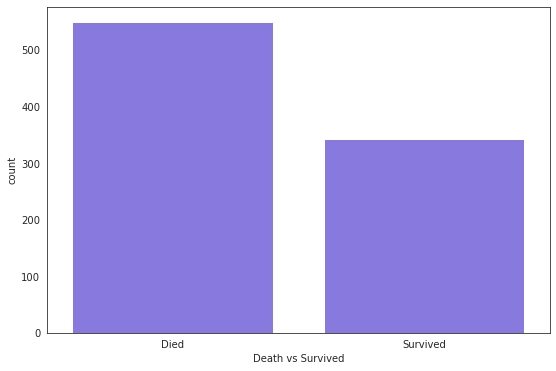

In [26]:
survive_data = pd.DataFrame()
survive_data['Survived'] = train['Survived'].apply(lambda x:'Died' if x==0 else 'Survived')
survive_data['Pclass'] = train['Pclass']
survive_data['Sex'] = train['Sex']

ax = sb.countplot(survive_data['Survived'], color=color)
ax.set(xlabel='Death vs Survived')

In [27]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


[Text(0.5, 0, 'Death vs Survived based Sex')]

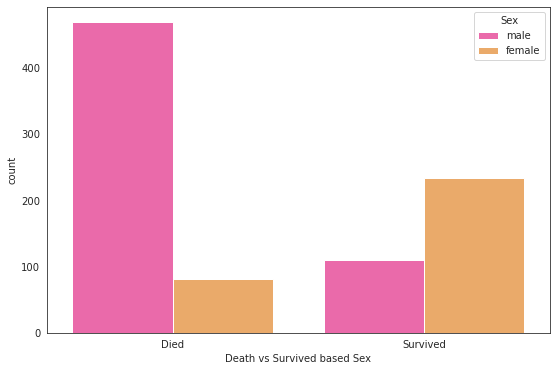

In [28]:
ax = sb.countplot(survive_data['Survived'], hue='Sex', palette='spring', data=survive_data)
ax.set(xlabel='Death vs Survived based Sex')

Based on the data visualization above, we can conclude that 'Female' are more likely to survive than men.

In [29]:
train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [30]:
train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


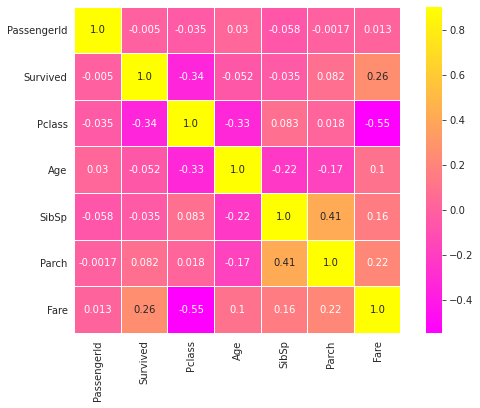

In [31]:
corrmat = train.corr()

sb.heatmap(corrmat, vmax=0.9, cmap="spring", annot=True, square=True, fmt='.2', linewidth='.1')

In [32]:
categorical_features = [col for col in train.columns
      if train[col].dtype=='object']

categorical_features

['Name', 'Sex', 'Ticket', 'Embarked']

In [33]:
numerical_features = [col for col in train.columns
      if train[col].dtype!='object']

numerical_features

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

### Adding features to our data.

In [34]:
all_data = [train, test]

for df in all_data:
    df['Name_length'] = df['Name'].apply(len)
    df['Family_size'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = df['Family_size'].apply(lambda x:0 if x>1 else 1)

In [35]:
train.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name_length,Family_size,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,23,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,51,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,22,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,44,2,0


Now we dont need the 'SibSp' and 'Parch' variables. So, lets drop em.

In [36]:
train.drop(['SibSp', 'Parch'], axis=1, inplace=True)
test.drop(['SibSp', 'Parch'], axis=1, inplace=True)

### The Fare variable

Convert it to 'int' datatype.

In [37]:
train['Fare'] = train['Fare'].astype(int)
test['Fare'] = test['Fare'].astype(int)

In [38]:
train['Fare'].head()

0     7
1    71
2     7
3    53
4     8
Name: Fare, dtype: int64

### The Sex variable
We can add a different field in 'Sex' variable as 'Child' if the age is less than 16 years.

In [39]:
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
train['Person'] = train[['Age','Sex']].apply(get_person,axis=1)
test['Person'] = test[['Age','Sex']].apply(get_person,axis=1)

In [40]:
# Drop the 'Sex' variable because we don't need it anymore
train.drop(['Sex'], axis=1, inplace=True)
test.drop(['Sex'], axis=1, inplace=True)

### Now we move on to the 'Name' variable

We can take out information from the title of the name and then map it to some numerical values.

In [41]:
for df in all_data:
    df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(1))

In [42]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Age,Ticket,Fare,Embarked,Name_length,Family_size,IsAlone,Person,Title
0,1,0,3,"Braund, Mr. Owen Harris",22,A/5 21171,7,S,23,2,0,male,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38,PC 17599,71,C,51,2,0,female,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",26,STON/O2. 3101282,7,S,22,1,1,female,Miss


In [43]:
train['Title'].nunique()

17

In [44]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Don           1
Countess      1
Mme           1
Lady          1
Jonkheer      1
Capt          1
Sir           1
Ms            1
Name: Title, dtype: int64

Except the top four 'titles', others are present in very few numbers and hence not fit to train the data on such small quantity. We will group them under a new 'title' and call it 'misc'.

In [45]:
# Note that 'Dona' is in test data
# Ms means miss, Mlle (mademoiselle) means miss, Mme (Madame) means miss
for df in all_data:
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Lady', 'Capt', 'Jonkheer', 'Sir', 'Don', 'Dona'], 'Rare')

In [46]:
train['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

In [47]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Age,Ticket,Fare,Embarked,Name_length,Family_size,IsAlone,Person,Title
0,1,0,3,"Braund, Mr. Owen Harris",22,A/5 21171,7,S,23,2,0,male,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38,PC 17599,71,C,51,2,0,female,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",26,STON/O2. 3101282,7,S,22,1,1,female,Miss


Lets take a quick look at all the categorical data present in our dataset!

In [48]:
numerical_data = X.select_dtypes(exclude=['object']).copy()

NameError: name 'X' is not defined

In [49]:
categorical_features = [col for col in train.columns
      if train[col].dtype=='object']

categorical_features

['Name', 'Ticket', 'Embarked', 'Person', 'Title']

## Dropping some variables
We can drop a few variables from our dataset, as they are no good to us.

In [50]:
train = train.drop(['Name', 'Ticket', 'PassengerId'], axis=1)
test = test.drop(['Name', 'Ticket', 'PassengerId'], axis=1)

In [51]:
train.head()

,Survived,Pclass,Age,Fare,Embarked,Name_length,Family_size,IsAlone,Person,Title
0,0,3,22,7,S,23,2,0,male,Mr
1,1,1,38,71,C,51,2,0,female,Mrs
2,1,3,26,7,S,22,1,1,female,Miss
3,1,1,35,53,S,44,2,0,female,Mrs
4,0,3,35,8,S,24,1,1,male,Mr


Alright, we now only have three categorical variables in our data that we need to take care of. We will use one-hot encoding for this purpose.

So far so good. We have made a good progress in feature engineering. Lets keep moving forward and cleaning our data for processing and modeling. 

## X-y split

In [52]:
# Store the target variable and drop it from the train dataset
X = train.drop(['Survived'], axis=1)
y = train['Survived']

In [53]:
# Filling numerical columns
num_cols = [col for col in X.columns if X[col].dtype!='object']
X.update(X[num_cols].fillna(0))
tst_num_cols = [col for col in test.columns if X[col].dtype!='object']
test.update(test[tst_num_cols].fillna(0))

# Filling categorical columns
cat_cols = [col for col in X.columns if X[col].dtype=='object']
X.update(X[cat_cols].fillna('None'))
test.update(test[cat_cols].fillna('None'))

In [54]:
# Using pd.get_dummies() to one-hot encode
X = pd.get_dummies(X)
test = pd.get_dummies(test)
X, test = X.align(test, join='left', axis=1)

In [55]:
X.head(3)

,Pclass,Age,Fare,Name_length,Family_size,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Person_child,Person_female,Person_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,22,7,23,2,0,0,0,1,0,0,1,0,0,1,0,0
1,1,38,71,51,2,0,1,0,0,0,1,0,0,0,0,1,0
2,3,26,7,22,1,1,0,0,1,0,1,0,0,1,0,0,0


In [56]:
test.head(3)

,Pclass,Age,Fare,Name_length,Family_size,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Person_child,Person_female,Person_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,34,7,16,1,1,0,1,0,0,0,1,0,0,1,0,0
1,3,47,7,32,2,0,0,0,1,0,1,0,0,0,0,1,0
2,2,62,9,25,1,1,0,1,0,0,0,1,0,0,1,0,0


Lets double check for any categorical data.

In [57]:
cat = [col for col in X.columns
       if X[col].dtype=='object']
cat

[]

Well, we don't have any categorical data in our datasets and our data looks good. This puts a smile on my face!

Lets keep moving forward!!!

# Visualization

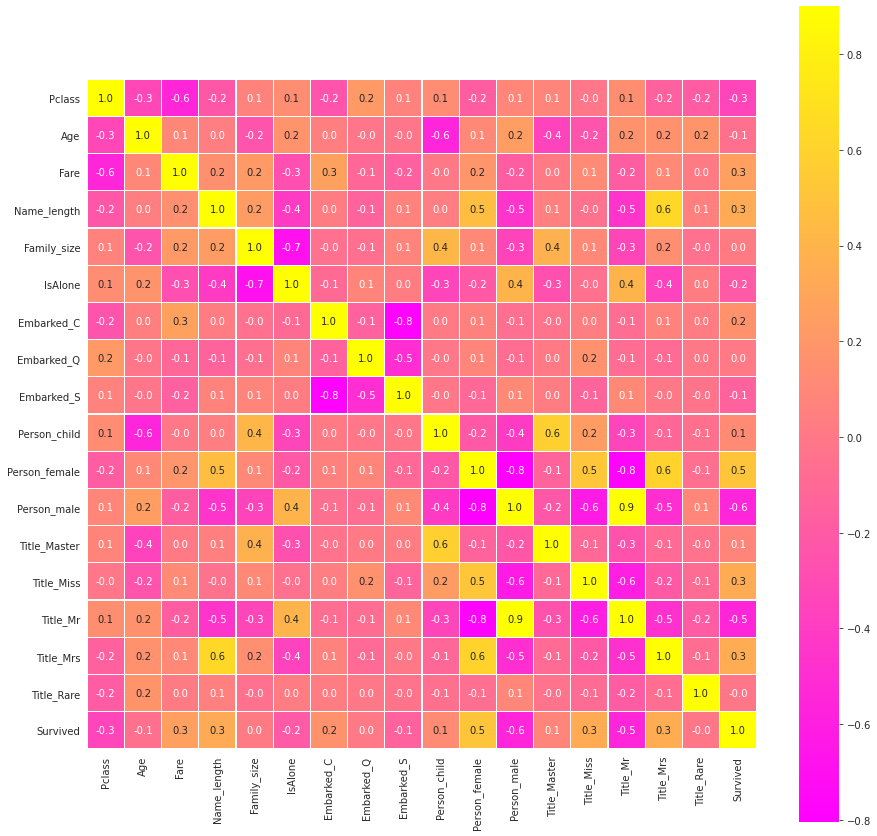

In [58]:
tmp_all = pd.concat([X, y], axis=1)
corrmat = tmp_all.corr()

plt.subplots(figsize=(15, 15))
sb.heatmap(corrmat, vmax=0.9, square=True, annot=True, cmap='spring', fmt='.1f', linewidth='.1')

In [59]:
the_imp_order = corrmat['Survived'].sort_values(ascending=False).head(11).to_frame()
the_imp_order

,Survived
Survived,1.000000
Person_female,0.508924
Title_Mrs,0.341994
Title_Miss,0.335636
Name_length,0.332350
Fare,0.257482
Embarked_C,0.168240
Person_child,0.125484
Title_Master,0.085221
Family_size,0.016639


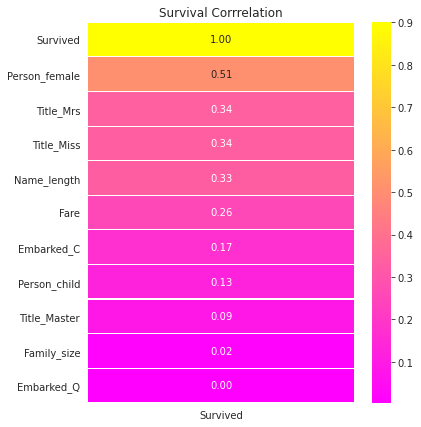

In [60]:
plt.subplots(figsize=(6, 7))
plt.title('Survival Corrrelation')
sb.heatmap(the_imp_order, vmax=0.9, annot=True, fmt='.2f', cmap="spring", linewidth='.1')

In [61]:
numerical_data = X.select_dtypes(exclude=['object']).copy()

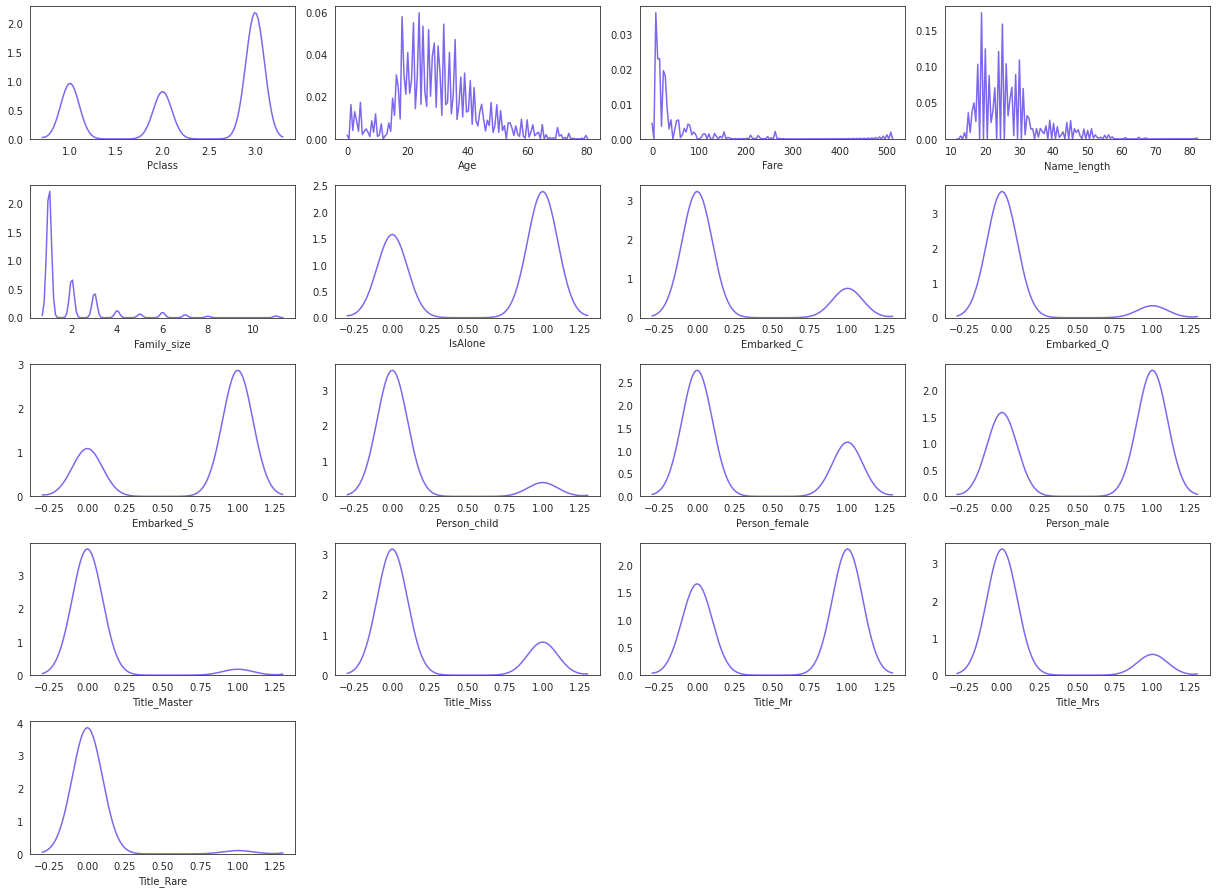

In [62]:
fig = plt.figure(figsize=(17,22))
for i in range(len(numerical_data.columns)):
    fig.add_subplot(9,4,i+1)
    sb.distplot(numerical_data.iloc[:,i].dropna(), hist=False, kde_kws={'bw':0.1}, color='mediumslateblue')
    plt.xlabel(numerical_data.columns[i])
plt.tight_layout()
plt.show()

## AGE

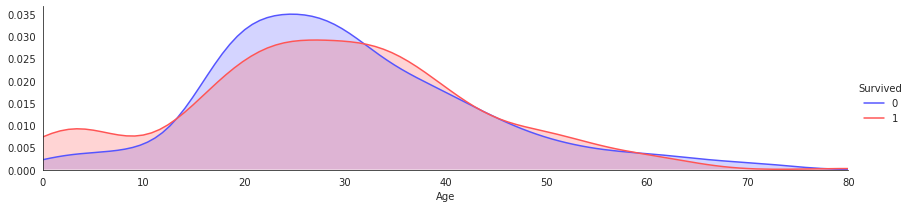

In [63]:
my_facet = sb.FacetGrid(tmp_all, hue="Survived",aspect=4, palette='seismic')
my_facet.map(sb.kdeplot,'Age',shade= True)
my_facet.set(xlim=(0, tmp_all['Age'].max()))
my_facet.add_legend()

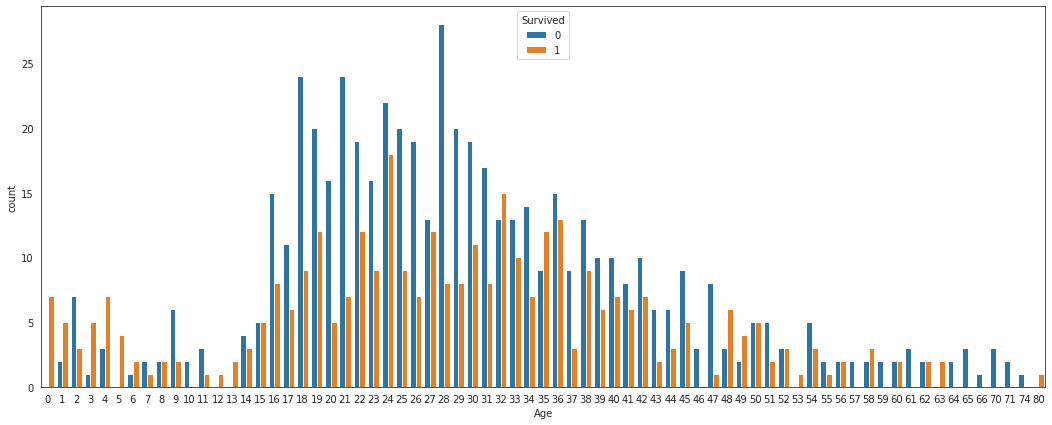

In [64]:
plt.subplots(figsize=(18, 7))
ax = sb.countplot(tmp_all['Age'], hue='Survived', data=tmp_all)

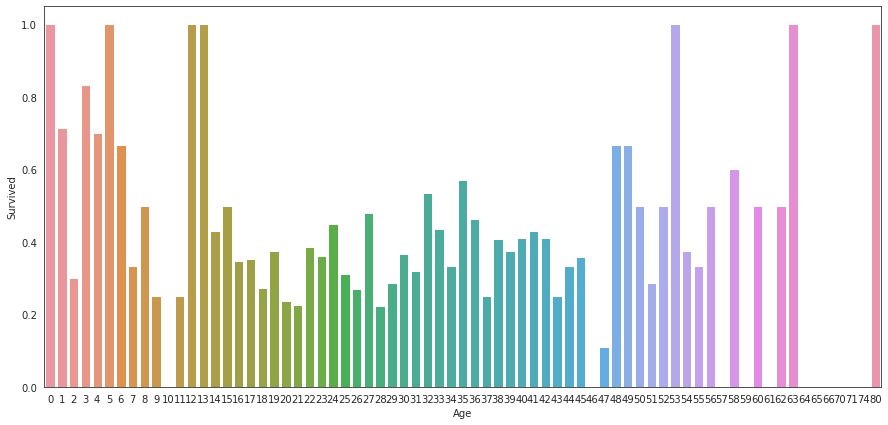

In [65]:
plt.subplots(figsize=(15, 7))
average_age = tmp_all[['Age', 'Survived']].groupby(['Age'], as_index=False).mean()
sb.barplot(x='Age', y='Survived', data=average_age)

## Ticket Class

In [66]:
tmp_all[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


[Text(0.5, 0, 'Death vs Survived based on Ticket class')]

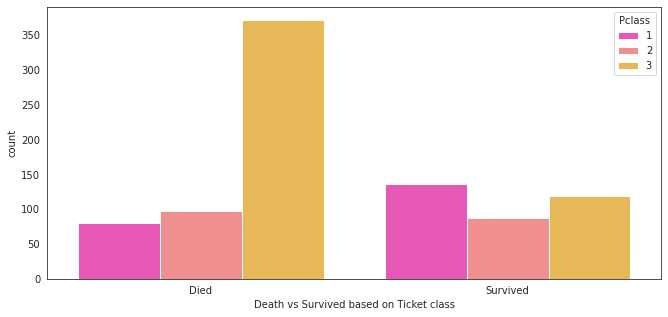

In [67]:
plt.subplots(figsize=(11, 5))
ax = sb.countplot(survive_data['Survived'], hue='Pclass', palette='spring', data=survive_data)
ax.set(xlabel='Death vs Survived based on Ticket class')

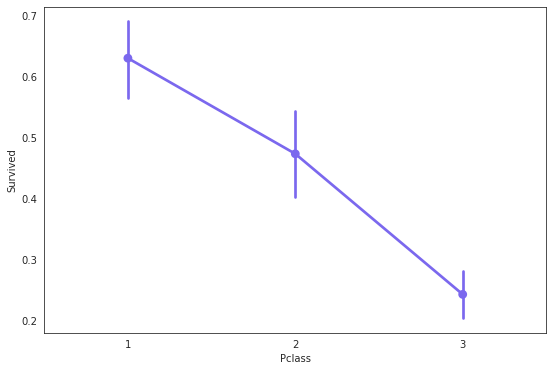

In [68]:
ax = sb.pointplot('Pclass', 'Survived', color=color, data=tmp_all)

From the countplot above, two things are very clear to us:
* People with ticket class 3 are more likely to die.
* People with ticket class 1 are more likely to survive.

## Person

In [69]:
display(tmp_all[['Person_female', 'Survived']].groupby(['Person_female'], as_index=False).mean().sort_values(by='Survived', ascending=False))
display(tmp_all[['Person_male', 'Survived']].groupby(['Person_male'], as_index=False).mean().sort_values(by='Survived', ascending=False))
display(tmp_all[['Person_child', 'Survived']].groupby(['Person_child'], as_index=False).mean().sort_values(by='Survived', ascending=False))

,Person_female,Survived
1,1,0.761194
0,0,0.221509


,Person_male,Survived
0,0,0.713483
1,1,0.164486


,Person_child,Survived
1,1,0.568182
0,0,0.363636


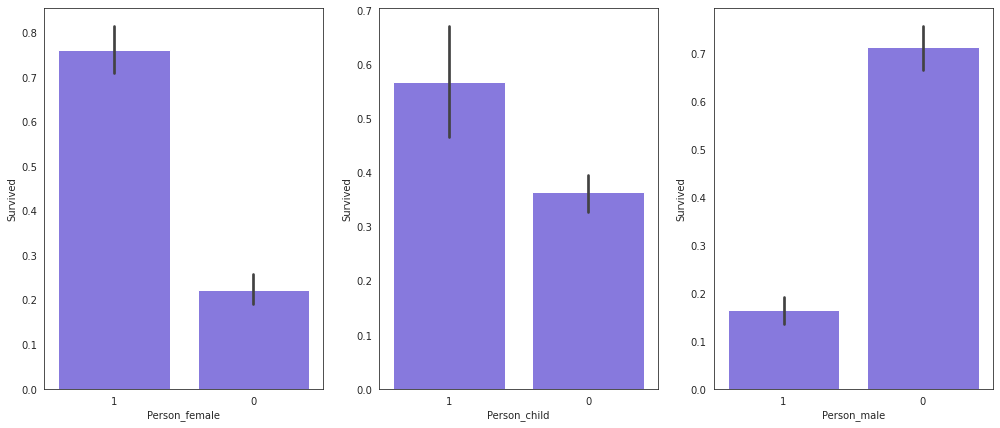

In [70]:
fig, (axis1,axis2, axis3) = plt.subplots(1,3,sharex=True,figsize=(17,7))
sb.barplot(tmp_all['Person_female'], tmp_all['Survived'], order=[1,0], ax=axis1, color=color)
sb.barplot(tmp_all['Person_child'], tmp_all['Survived'], order=[1,0], ax=axis2, color=color)
sb.barplot(tmp_all['Person_male'], tmp_all['Survived'], order=[1,0], ax=axis3, color=color)

## Family

In [71]:
tmp_all[['Family_size', 'Survived']].groupby(['Family_size'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Family_size,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


[Text(0.5, 0, 'Size of the Family')]

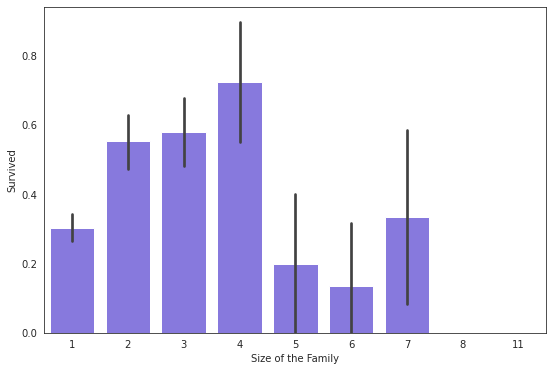

In [72]:
ax = sb.barplot(x=tmp_all['Family_size'], y=tmp_all['Survived'], color=color)
ax.set(xlabel='Size of the Family')

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Size of Family')]

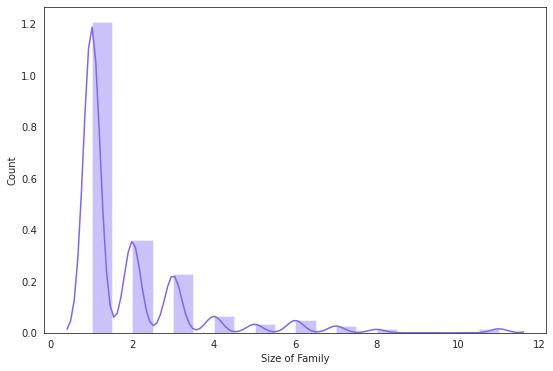

In [73]:
ax = sb.distplot(tmp_all['Family_size'], color=color, bins=20)
ax.set(xlabel='Size of Family', ylabel='Count')

## Is Alone?

Now lets see if the chances of survival increases if the person is alone?

In [74]:
tmp_all[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


[Text(0.5, 0, 'Is the person alone or not?')]

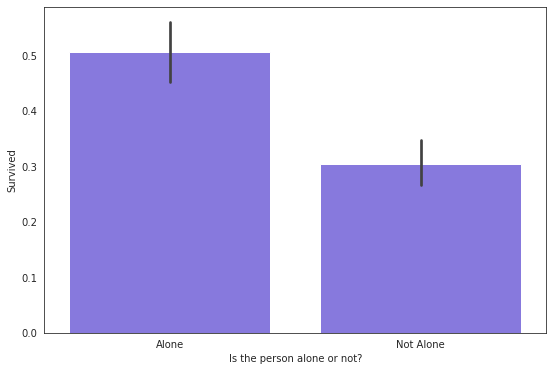

In [75]:
tmp_all['IsAlone'] = tmp_all['IsAlone'].apply(lambda x: 'Alone' if x==0 else 'Not Alone')
ax = sb.barplot(x=tmp_all['IsAlone'], y=tmp_all['Survived'], color=color)
ax.set(xlabel='Is the person alone or not?')

## Moving On

In [76]:
X.head()

,Pclass,Age,Fare,Name_length,Family_size,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Person_child,Person_female,Person_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,22,7,23,2,0,0,0,1,0,0,1,0,0,1,0,0
1,1,38,71,51,2,0,1,0,0,0,1,0,0,0,0,1,0
2,3,26,7,22,1,1,0,0,1,0,1,0,0,1,0,0,0
3,1,35,53,44,2,0,0,0,1,0,1,0,0,0,0,1,0
4,3,35,8,24,1,1,0,0,1,0,0,1,0,0,1,0,0


In [77]:
f = [col for col in X.columns
    if X[col].dtype!='int64']
f

['Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Person_child',
 'Person_female',
 'Person_male',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Rare']

In [78]:
change_ftr = ['Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Person_child',
 'Person_female',
 'Person_male',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Rare']

X[change_ftr] = X[change_ftr].astype(int)
test[change_ftr] = test[change_ftr].astype(int)

In [79]:
tmp_all.columns

Index(['Pclass', 'Age', 'Fare', 'Name_length', 'Family_size', 'IsAlone',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Person_child',
       'Person_female', 'Person_male', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Survived'],
      dtype='object')

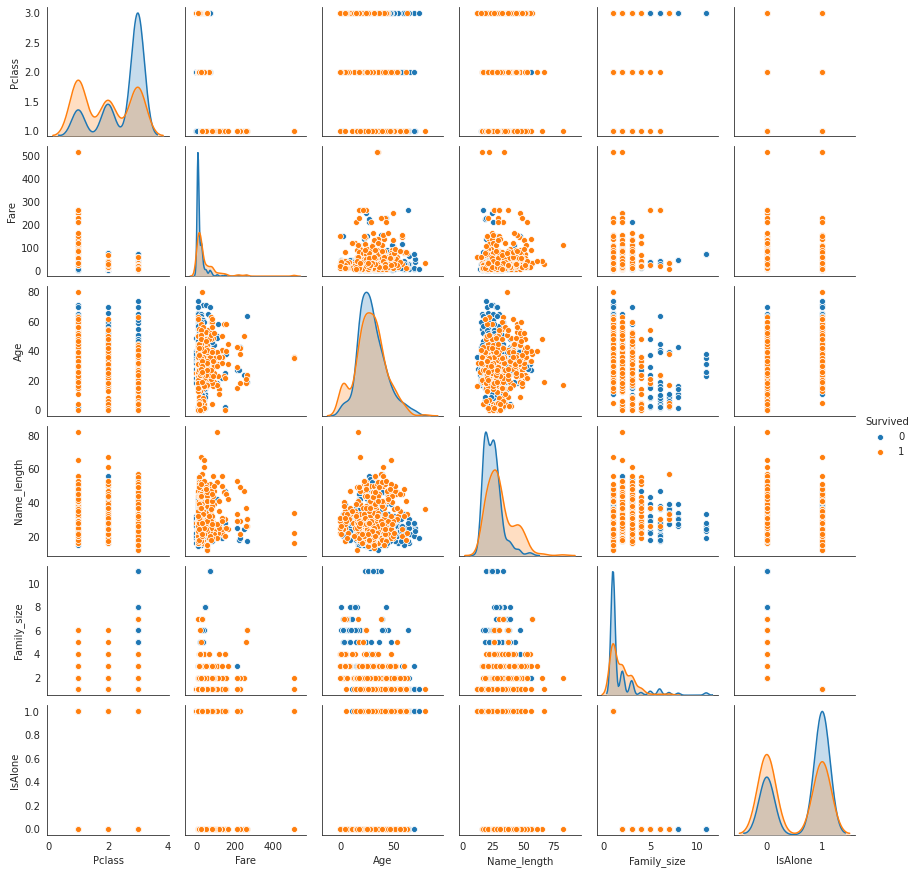

In [80]:
tmp_all = pd.concat([X.copy(), y.copy()], axis=1)
sb.pairplot(tmp_all[['Survived', 'Pclass', 'Fare', 'Age', 'Name_length', 'Family_size', 'IsAlone']], hue='Survived', height=2, diag_kind='kde')

# Modeling

### this is a classification problem

In [81]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier

In [82]:
def rmse(model, X, y):
    scores = np.sqrt(-1 * cross_val_score(model, X, y,
                        cv=10, 
                        scoring='neg_mean_squared_error'))
    return scores

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [83]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=2)

In [84]:
Scores = {}

In [85]:
xgb = XGBClassifier(n_estimators=500,
                   learning_rate=0.01,
                   colsample_bytree=0.45,
                   max_depth=3,
                   gamma=0,
                   reg_alpha=0,
                   reg_lambda=0,
                   objective='reg:squarederror')

scores = rmse(xgb, train_X, train_y)
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))

Scores['XGB'] = scores.mean()

Root Mean Square Error (RMSE) 0.4019632068146629
Error Standard Deviation 0.036556510902139856


In [86]:
svc = SVC(C= 0.025, kernel='linear')


scores = rmse(svc, train_X, train_y)
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))

Scores['SVR'] = scores.mean()

Root Mean Square Error (RMSE) 0.40584322681636803
Error Standard Deviation 0.03282773558751622


In [87]:
gbr = GradientBoostingClassifier(n_estimators=500,
                                learning_rate=0.01,
                                max_depth=5)


scores = rmse(gbr, train_X, train_y)
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))

Scores['GBR'] = scores.mean()

Root Mean Square Error (RMSE) 0.4058879566762819
Error Standard Deviation 0.06116275106721753


In [88]:
lgb = LGBMClassifier(num_leaves=4,
                       learning_rate=0.01, 
                       n_estimators=900,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=3, 
                       bagging_seed=5,
                       feature_fraction=0.5,
                       feature_fraction_seed=5,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

scores = rmse(lgb, train_X, train_y)
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))

Scores['LGB'] = scores.mean()

Root Mean Square Error (RMSE) 0.3994463040815269
Error Standard Deviation 0.05773981695795007


In [89]:
# vote_set = [('svc', svc),
#             ('xgb', xgb),
#             ('lgb', lgb),
#             ('gbr', gbr),
#            ]

In [90]:
stack = StackingCVClassifier(classifiers=(gbr, xgb, svc, lgb),
                            meta_classifier=xgb,
                            random_state=42)

## Fit the models

In [91]:
xgb.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=0, reg_alpha=0,
              reg_lambda=0, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [92]:
svc.fit(train_X, train_y)

SVC(C=0.025, kernel='linear')

In [93]:
gbr.fit(train_X, train_y)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=500)

In [94]:
lgb.fit(train_X, train_y)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=3, bagging_seed=5,
               feature_fraction=0.5, feature_fraction_seed=5,
               learning_rate=0.01, max_bin=200, min_sum_hessian_in_leaf=11,
               n_estimators=900, num_leaves=4, random_state=42, verbose=-1)

In [95]:
stack.fit(np.array(train_X), np.array(train_y))

StackingCVClassifier(classifiers=(GradientBoostingClassifier(learning_rate=0.01,
                                                             max_depth=5,
                                                             n_estimators=500),
                                  XGBClassifier(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=0.45, gamma=0,
                                                gpu_id=-1,
                                                importance_type='gain',
                                                interaction_constraints='',
                                                learning_rate=0.01,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight

In [96]:
# voting = VotingClassifier(estimators = vote_set , voting = 'hard')
# voting.fit(train_X, train_y)

In [97]:
# scores = rmse(voting, train_X, train_y)
# print("Root Mean Square Error (RMSE)", str(scores.mean()))
# print("Error Standard Deviation", str(scores.std()))

In [98]:
def blended_predictions(X):
    return ((0.15 * svc.predict(X)) + \
            (0.15 * gbr.predict(X)) + \
            (0.15 * xgb.predict(X)) + \
            (0.05 * lgb.predict(X)) + \
           (0.4 * stack.predict(np.array(X))))

In [99]:
blended_score = rmsle(valid_y, blended_predictions(valid_X))

Scores['Blended'] = blended_score
blended_score

0.431073105570701

In [100]:
preds = np.ceil(blended_predictions(test)).astype(int)

In [101]:
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": preds
    })
submission.to_csv('titanic.csv', index=False)


In [102]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [103]:
submission.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
